In [2]:
%matplotlib inline
#import warnings; warnings.simplefilter('always')

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from scipy import optimize
from scipy.optimize import curve_fit

import os
from functools import reduce
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import math

/Users/eisen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


This notebook looks at fitting time series data, in particular exponential decay data from mRNA stability experiments.


The first thing we're going to do is model some exponential decay curves and look at the effect of noise on fits.

In [4]:
# a simple exponential decay function
# takes a vector of times t
# a starting value
# and a half life t2 (can't really write t 1/2)

def decayfunc(t,A0,t2):
    return A0 * np.power(2,-t/t2)

Text(0.5, 0, 'time')

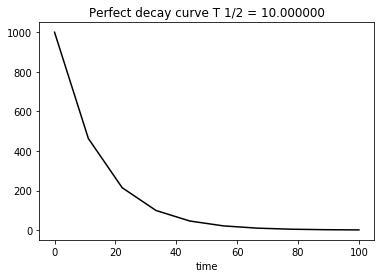

In [5]:
#
# what does decay curve look like
#

# range of times we'll plot
t0 = 0
t_end = 100

# number of time points
n = 10

# half life to model
t2 = 10

A0 = 1000

times = np.linspace(t0,t_end,n)
decay = decayfunc(times,A0,t2)

plt.plot(times,decay, c='black')
plt.title("Perfect decay curve T 1/2 = %f" % t2)
plt.xlabel("time")

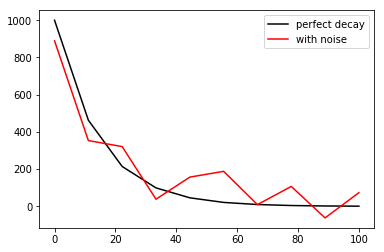

In [9]:
# now lets add some noise

t0 = 0
t_end = 100
t2 = 10
n = 10
A0 = 1000

times = np.linspace(t0,t_end,n)
decay = decayfunc(times,A0,t2)

plt.plot(times,decay, c='black', label = "perfect decay")

# add normally distributed noise 
decay_n = decayfunc(times,A0,t2) + np.random.normal(0,100,n)

plt.plot(times,decay_n, c='red', label = "with noise")
plt.legend()

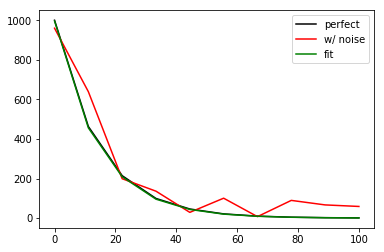

In [10]:
t0 = 0
t_end = 100
t2 = 10
n = 10
A0 = 1000

times = np.linspace(t0,t_end,n)

decay = decayfunc(times,A0,t2) + np.random.normal(0,5,n)

# fit curve to noisy data 

xdata = times
ydata = decay

fit,cv = curve_fit(decayfunc,xdata,ydata, diag=(1./xdata.mean(),1./ydata.mean()))

plt.plot(times,decayfunc(times,A0,t2),c='black', label='perfect')
plt.plot(times,d,c='red',label='w/ noise')
plt.plot(times,decayfunc(times,fit[0],fit[1]),c='green', label='fit')

plt.legend()

[ 987.00272417   12.5002666 ]


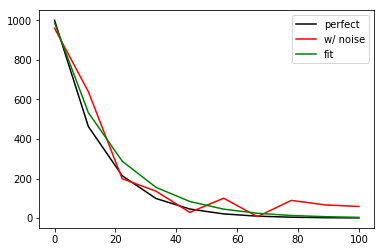

In [11]:
t0 = 0
t_end = 100
t2 = 10
n = 10
A0 = 1000

times = np.linspace(t0,t_end,n)

decay = decayfunc(times,A0,t2) + np.random.normal(0,100,n)

# fit curve to noisy data 

xdata = times
ydata = decay

fit,cv = curve_fit(decayfunc, times, d, bounds=( (A0/2,t2/2) , (2*A0,t2*2)) )

print (fit)

plt.plot(times,decayfunc(times,A0,t2),c='black', label='perfect')
plt.plot(times,d,c='red',label='w/ noise')
plt.plot(times,decayfunc(times,fit[0],fit[1]),c='green', label='fit')
plt.legend()

In [14]:
# how well do we recover the half lives with different amounts of noise

t0 = 0
t_end = 100
n = 10
A0 = 1000

times = np.linspace(t0,t_end,n)

trials = 1000
noise = 100


x = []
y = []

for t in range(0,trials):
    t2 = 5.0 + 50 * np.random.random()
    decay = decayfunc(times,A0,t2) + np.random.normal(0,noise,n)
    xdata = times
    ydata = decay

    #fit,cv = curve_fit(decayfunc,xdata,ydata, diag=(1./xdata.mean(),1./ydata.mean()))
    fit,cv = curve_fit(decayfunc,xdata,ydata, bounds=( (ydata[0]/2,0) , (2*ydata[0],100)) )

    x.append(t2)
    y.append(fit[1])

Text(0, 0.5, 'fit half life')

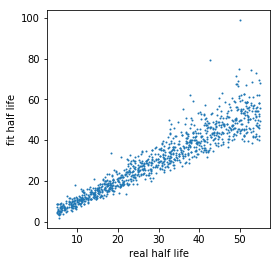

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y,s=1)
ax.set_xlabel("real half life")
ax.set_ylabel("fit half life")

In [38]:
datafile = "data/rna_decay/decaydata.spike.norm"
df = pd.read_csv(datafile,sep="\t")
df = df.drop(df.index[[0,1,2]])
df = df.set_index('gene_id')

bad = ['YBL071C-B',
 'YBR221W-A',
 'YDR320W-B',
 'YER046W-A',
 'YGL006W-A',
 'YJL136W-A',
 'YKL106C-A',
 'YLR279W',
 'YMR052C-A',
 'YMR247W-A',
 'YOR161C-C']

df = df.drop(bad)

df = df[df['T1'] > 50]

In [74]:
datacols = []
times = []
for i in range(1,13):
    datacols.append("T%d" % i)
    times.append((i-1) * 5.0)
    
times = np.array(times)

In [75]:
def decayfunc(t,A0,t2):
    return A0 * np.power(2,-t/t2)

fits = []

for i,r in df.iterrows():
    
    data = np.array(r[datacols].values,dtype=float) 
    guess = np.array([data[0],10.0])
    fit,covp = curve_fit(decayfunc, times, data, guess, bounds=( (data[0]/2,0.0) , (2*data[0],50.0)) )
    fits.append(fit)
    
fits = np.matrix(fits)

df['A0'] = fits[:,0]
df['t_half'] = fits[:,1]

In [76]:
df

,gene_short_name,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,A0,t_half
gene_id,,,,,,,,,,,,,,,
Q0050,AI1,53.854281,24.967534,29.987314,18.008157,28.194435,16.107006,18.229885,18.307994,24.975402,19.612700,15.963094,22.557377,37.318367,39.198138
Q0105,COB,50.833248,23.027145,31.295144,32.578731,28.678246,44.937868,31.984916,36.752400,34.899172,49.693900,42.947819,62.184247,51.173628,50.000000
Q0130,OLI1,6435.256156,4096.284984,5686.458722,5673.301253,6001.821892,5253.644103,4781.312472,4820.246347,4933.579746,5006.420000,5888.816297,4575.242599,7154.328193,50.000000
Q0250,COX2,94.548347,73.478080,76.936774,62.565768,80.725041,83.028108,53.026836,90.950679,55.562155,76.870700,94.709704,53.740206,101.781177,50.000000
Q0275,COX3,74.377834,44.619553,35.039817,36.726682,23.220081,30.495250,19.525770,47.533775,23.618084,25.461600,23.315751,30.594125,54.291938,37.239761
YAL003W,EFB1,10250.385453,8043.230707,5468.154375,3894.706498,3168.506122,2125.628121,1408.457686,1016.522331,789.491036,544.284000,457.466815,526.903815,10459.585626,10.968410
YAL005C,SSA1,2167.686917,2059.039777,1589.791829,1095.657574,768.427032,427.612158,259.725259,164.581898,88.590124,61.114900,43.816019,27.134807,2445.121768,11.558600
YAL007C,ERP2,1120.314784,721.329721,424.474380,207.436487,80.997329,54.944764,47.693087,33.367850,23.027004,28.961800,31.825286,31.319889,1144.455884,6.543658
YAL008W,FUN14,152.935591,105.365241,47.282014,39.060640,25.861936,15.049014,12.678625,16.755228,5.203223,9.816420,17.978236,7.077106,152.759433,7.706568


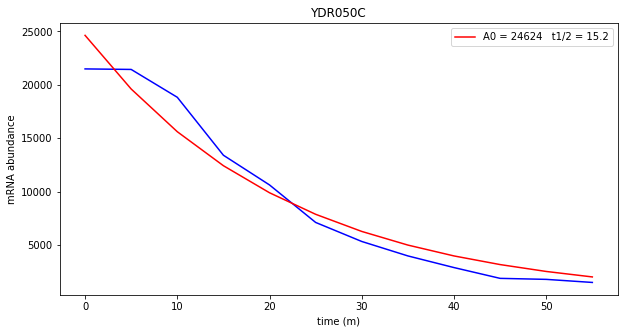

In [77]:
gene = 'YDR050C'

r = df.loc[gene]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(times,np.array(r[datacols].values), c='blue')
ax.plot(times,decayfunc(times,r['A0'],r['t_half']), c='red', label = "A0 = %d   t1/2 = %.1f" % (r['A0'],r['t_half']))
ax.set_xlabel('time (m)')
ax.set_ylabel('mRNA abundance')
ax.set_title(gene)
ax.legend()

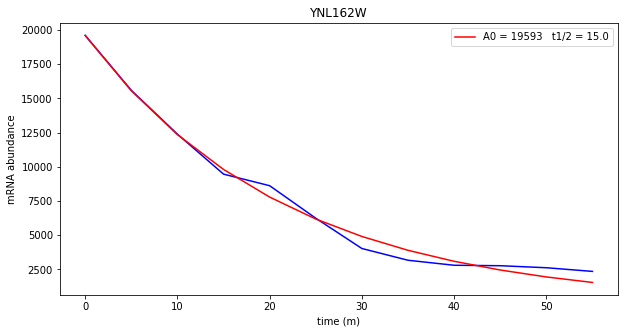

In [78]:
r = df[(df.t_half > 5.0) & (df.t_half < 25.0)].sample(1).iloc[0]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(times,np.array(r[datacols].values), c='blue')
ax.plot(times,decayfunc(times,r['A0'],r['t_half']), c='red', label = "A0 = %d   t1/2 = %.1f" % (r['A0'],r['t_half']))
ax.set_xlabel('time (m)')
ax.set_ylabel('mRNA abundance')
ax.set_title(r.name)
ax.legend()

(array([ 2214.,  1186.,   342.,   169.,    83.,    36.,    17.,    11.,
            3.,    33.]),
 array([  0.26478667,   5.238308  ,  10.21182933,  15.18535067,
         20.158872  ,  25.13239333,  30.10591467,  35.079436  ,
         40.05295733,  45.02647867,  50.        ]),
 <a list of 10 Patch objects>)

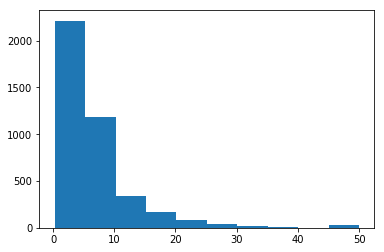

In [79]:
plt.hist(df['t_half'].values)

In [80]:
df.to_csv("data/rna_decay/data.csv")

In [81]:
ginfo = pd.read_csv("data/rna_decay/geneinfo.csv")

In [82]:
ginfo = ginfo.set_index("GID")

In [83]:
df2 = df.join(ginfo, how='left')

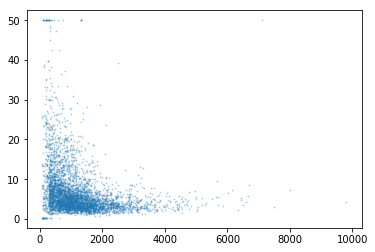

In [87]:
plt.scatter(df2.length,df2.t_half,s=1,alpha=.25)

In [88]:
cdf = pd.read_csv("data/rna_decay/CYC2008_complex.tab", sep='\t')

In [93]:
cdf

,ORF,Name,Complex,PubMed_id,Method,GO_id,GO_term,Jaccard_Index
0,YKR068C,BET3,TRAPP complex,10727015.0,"Affinity Capture-Western,Affinity Capture-MS",GO:0030008,TRAPP complex,1.000000
1,YML077W,BET5,TRAPP complex,NaN,NaN,NaN,NaN,NaN
2,YDR108W,GSG1,TRAPP complex,NaN,NaN,NaN,NaN,NaN
3,YGR166W,KRE11,TRAPP complex,NaN,NaN,NaN,NaN,NaN
4,YDR407C,TRS120,TRAPP complex,NaN,NaN,NaN,NaN,NaN
5,YMR218C,TRS130,TRAPP complex,NaN,NaN,NaN,NaN,NaN
6,YBR254C,TRS20,TRAPP complex,NaN,NaN,NaN,NaN,NaN
7,YDR246W,TRS23,TRAPP complex,NaN,NaN,NaN,NaN,NaN
8,YDR472W,TRS31,TRAPP complex,NaN,NaN,NaN,NaN,NaN
9,YOR115C,TRS33,TRAPP complex,NaN,NaN,NaN,NaN,NaN


In [102]:
xp = 0

x = []
y = []

for cplx, g in cdf.groupby("Complex"):
    ldf = df2[df2.index.isin(g.ORF)]
    if len(ldf) > 5:
        xp += 1
        for i,r in ldf.iterrows():
            x.append(xp)
            y.append(r.t_half)

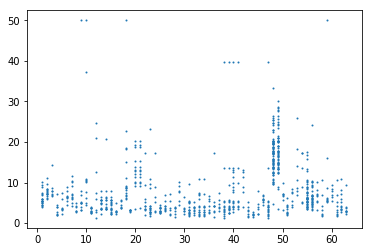

In [104]:
plt.scatter(x,y,s=1)

In [61]:
from intermine.webservice import Service
service = Service("https://yeastmine.yeastgenome.org:443/yeastmine/service", token = "R1T6a9J4AfvcWcf0C25d")
query = service.new_query("Gene")

#query.add_view(
#    "primaryIdentifier", "secondaryIdentifier", "organism.shortName", "symbol",
#    "name", "length", "phenotypeSummary", "functionSummary", "introns.length",
#    "introns.status", "transcripts.symbol", "transcripts.length"
#)

query.add_view(
    "primaryIdentifier", "secondaryIdentifier", "organism.shortName", "symbol",
    "name", "length", "phenotypeSummary", "functionSummary"
)

query.add_constraint("Gene", "IN", "Gene list for S. cerevisiae 5 Mar 2019 13.19", code = "A")


data = []
for row in query.rows():
    data.append([row["secondaryIdentifier"],row["symbol"], row["name"], row["length"], row["phenotypeSummary"], row["functionSummary"]])

In [64]:
ginfo = pd.DataFrame(data=data,columns=['GID','symbol','name','length','phenotype','function'])
ginfo = ginfo.set_index("GID")

In [65]:
ginfo

,symbol,name,length,phenotype,function
GID,,,,,
YOL030W,GAS5,Glycophospholipid-Anchored Surface protein,1455,None,None
YER177W,BMH1,Brain Modulosignalin Homolog,804,Non-essential gene; null mutation results in i...,Phosphoserine- and DNA replication origin-bind...
YDR099W,BMH2,Brain Modulosignalin Homolog,822,Non-essential gene; null mutation results in i...,Phosphoserine- and DNA replication origin-bind...
YPR082C,DIB1,S. pombe DIm1+ in Budding yeast,432,Essential gene; conditional or reduction-of-fu...,Subunit of the U4/U6 x U5 tri-small nuclear RN...
YIR022W,SEC11,SECretory,504,None,None
YDL052C,SLC1,SphingoLipid Compensation,912,None,None
YHR063C,PAN5,PANtothenate biosynthesis,1140,None,None
YHR044C,DOG1,DeOxyGlucose,741,None,None
YHR043C,DOG2,DeOxyGlucose,741,None,None


In [66]:
ginfo.to_csv("data/rna_decay/geneinfo.csv")